In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import pickle
import os
import pandas as pd
from netCDF4 import Dataset
import h5py

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If available, print the name of the GPU
if cuda_available:
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")


CUDA available: True
Device name: NVIDIA A30 MIG 1g.6gb
Device count: 1


In [3]:
class TruncatedNormalBetaNLL(nn.Module):
    """
    A truncated-normal modification of the beta-NLL loss presented in 
    Seitzer et al. (2022) "On the Pitfalls of Heteroscedastic Uncertainty 
    Estimation with Probabilistic Neural Networks"
    """
    
    def __init__(self, beta, a=-1, b=1, epsilon=1e-10): 
        super(TruncatedNormalBetaNLL, self).__init__()
        self.beta = beta
        self.a = a
        self.b = b
        self.epsilon = epsilon
        self.normal_Z = torch.tensor(1 / np.sqrt(2 * np.pi), dtype=torch.float32)
    
    def forward(self, mean, variance, target):

        normal_NLL_loss = 0.5 * (variance.log() + (mean - target)**2 / variance) - self.normal_Z.log()

        if self.beta > 0:
            normal_NLL_loss = normal_NLL_loss * (variance.detach() ** self.beta)
        
        truncated_normal_scaling = torch.log(0.5 * torch.erf((self.b - mean)/torch.sqrt(2 * variance + self.epsilon)) \
             - 0.5 * torch.erf((self.a - mean)/torch.sqrt(2 * variance + self.epsilon)) + self.epsilon)

        loss = normal_NLL_loss + truncated_normal_scaling 
        
        return torch.mean(loss)

class NormalBetaNLL(nn.Module):
    def __init__(self, beta): 
        super(NormalBetaNLL, self).__init__()
        self.beta = beta
        self.normal_Z = torch.tensor(1 / np.sqrt(2 * np.pi), dtype=torch.float32)
    
    def forward(self, mean, variance, target):

        normal_NLL_loss = 0.5 * (variance.log() + (mean - target)**2 / variance) - self.normal_Z.log()

        if self.beta > 0:
            normal_NLL_loss = normal_NLL_loss * (variance.detach() ** self.beta)
                
        return torch.mean(normal_NLL_loss)


class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()

    def forward(self, output, target):
        return torch.mean((target - output)**2)

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=2):
        super(MLP, self).__init__()
        
        self.mean = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, 1),
                                    nn.Tanh())
        self.var = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.Sigmoid(),
                                    nn.Linear(hidden_size, 1),
                                    nn.Softplus())
            
    def forward(self, x):
        return self.mean(x), self.var(x)
    


In [4]:
np.random.seed(42)

# Generate 1000 samples of x from the interval [0, 5]
x = np.sort(np.random.uniform(0, 6, 1000))
x_test = np.sort(np.random.uniform(0, 10, 500))

# Generate epsilon_1 and epsilon_2 as random variables from a normal distribution with mean 0 and std 0.3
epsilon_1 = np.random.normal(0, 0.02, 1000)
epsilon_2 = np.random.normal(0, 0.02, 1000)

# test regression function 
def f(x): 
    return np.sin(3 * x) / 5 + epsilon_1 * x + epsilon_2 

f_x = f(x)

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Adding a dimension for the input
y_tensor = torch.tensor(f_x, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)  # Adding a dimension for the test input


In [43]:
def train_MLP_toy_regression(beta, train_m_v_separately, distribution):
    if distribution == "truncated_normal":
        criterion = TruncatedNormalBetaNLL(beta=beta)
    elif distribution == "normal":
        criterion = NormalBetaNLL(beta=beta)
    else: 
        raise ValueError("distribution needs to be truncated_normal or normal")
    
    torch.manual_seed(123)

    model = MLP(hidden_size=50)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        mean, _ = model(x_tensor)
        mean = mean.flatten()
        
        if train_m_v_separately and epoch < 5000: 
            var = torch.tensor([0.002])
            
        loss = criterion(mean, var, y_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        mean_train, var_train = model(x_tensor)
        mean_test, var_test = model(x_test_tensor)

    return mean_test.numpy().squeeze(), var_test.numpy().squeeze()


In [6]:
torch.manual_seed(123)

model = MLP(hidden_size=50)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = MSE()

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    mean, var = model(x_tensor)
    mean = mean.flatten()
    var = var.flatten()
        
    loss = criterion(mean, y_tensor)
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    mean_train, _ = model(x_tensor)
    mean_test, _ = model(x_test_tensor)



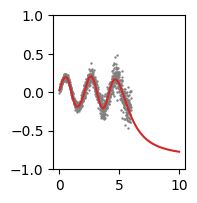

In [24]:
plt.figure(figsize=(1.7,2))
plt.scatter(x_tensor, y_tensor, color='grey', s=0.5) 
plt.plot(x_test_tensor, mean_test, color="tab:red")
plt.ylim([-1, 1])
plt.savefig("../figures/toy_regression/MSE_prediction.jpg", dpi=300, bbox_inches='tight')

In [47]:
results = {}
for beta in [0, 0.25, 0.5, 0.75, 1]:
    results[beta] = [train_MLP_toy_regression(beta, train_m_v_separately=True, distribution="truncated_normal"), \
                     train_MLP_toy_regression(beta, train_m_v_separately=False, distribution="truncated_normal"), \
                     train_MLP_toy_regression(beta, train_m_v_separately=True, distribution="normal"), \
                     train_MLP_toy_regression(beta, train_m_v_separately=False, distribution="normal")]

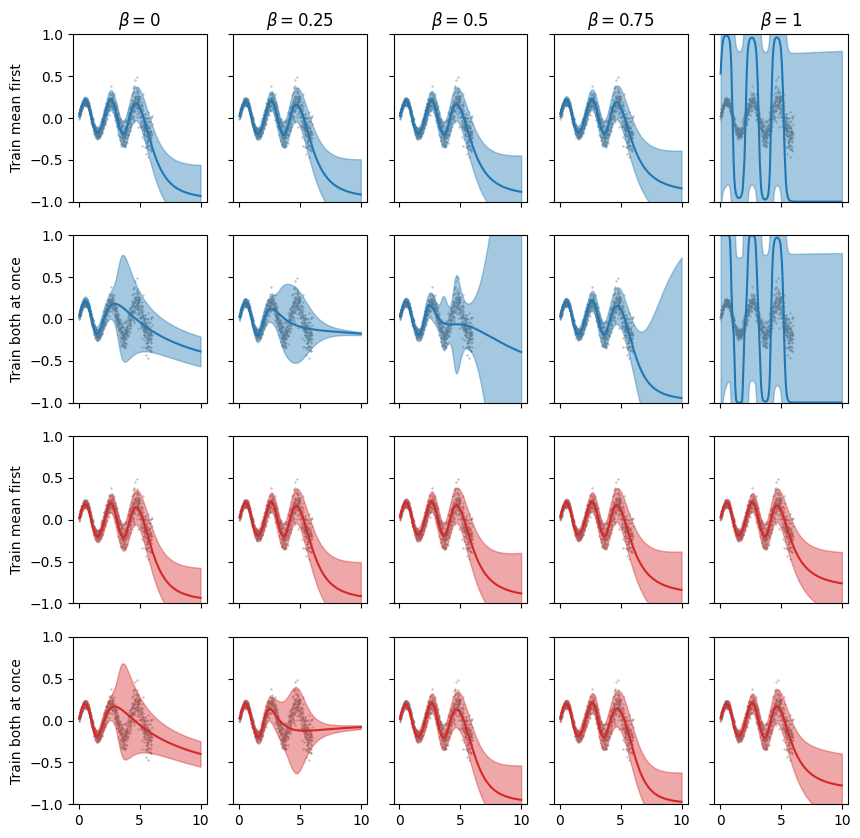

In [55]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,10), sharex=True, sharey=True)

for i, beta in enumerate([0, 0.25, 0.5, 0.75, 1]):
    for j in range(4):
        ax = axs[j,i]

        # plot the actual points
        ax.scatter(x_tensor, y_tensor, color='grey', s=0.1)

        # get the predictions
        mean = results[beta][j][0]
        stdev = np.sqrt(results[beta][j][1])

        color = "tab:blue" if j < 2 else "tab:red"
        ax.plot(x_test_tensor, mean, color=color)
        ax.fill_between(x_test_tensor.squeeze(), (mean - 2*stdev).squeeze(), (mean + 2*stdev).squeeze(), alpha=0.4, color=color)
        ax.set_ylim([-1, 1])
        
        if j == 0: ax.set_title(rf"$\beta = {beta}$")

axs[0,0].set_ylabel("Train mean first")
axs[1,0].set_ylabel("Train both at once")
axs[2,0].set_ylabel("Train mean first")
axs[3,0].set_ylabel("Train both at once")

plt.savefig("../figures/toy_regression/training_sched_beta_comparison.jpg", dpi=300, bbox_inches='tight')